# MODEL RSA2 -- Fixed Before Conditional Trials

#### Representational dissimilarity between correct and incorrect trials
#### Contains only fixed-before-conditional trials without intervening BLs
#### Combines A & C trials into single regressor
#### Accounts for last three noisy volumes in Lvl 1 analysis (FSL ROI -- ExtractROI)

## Compares activation for regions of interest using binarized masks:
#### Hippocampus (FS labels: hippocampus [17,53])
#### Medial PFC (FS labels: caudal anterior cingulate, rostral anterior cingulate)
#### Dorsal Caudate (hand-drawn by Mandy)
#### Putamen (FS labels: putamen [12,51])
#### Ventral Visual Area (FS labels: fusiform, lingual,  parahippocampal [1007,2007,1013,2013,1016,2016])
#### Dorsolateral PFC (FS labels: caudal middle frontal, lateral orbital frontal, rostral middle frontal [1003,2003,1012,2012,1027,2027])
#### Pars Triangularis (FS labels: triangularis [1020,2020])

In [1]:
import os
import re
from os.path import join
from glob import glob
import nibabel as nb
import pandas as pd
import numpy as np
from scipy import stats
from math import sqrt
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette('muted')
sns.set_style("white")

sidsX = ['WMAZE_001', 'WMAZE_002']
sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', 
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

proj_dir = '/home/data/madlab/Mattfeld_WMAZE/'
masks = [] #list of lists - sublist for each sub
copes = [] 

for i, SID in enumerate(sids):
    masks_glob = glob(proj_dir+'derivatives/roi_masks/hamm/anat_masks/_subject_id_'+SID+'/_anatmask_xfm*/*')
    masks.append(sorted(masks_glob)) #append sorted ROI masks
    copes_glob = glob(proj_dir+'Hamm_Learning/RSA2/lvl1/'+SID+'/modelfit/contrasts/_estimate_model*/cope??_onset*')
    copes.append(sorted(copes_glob)) #append sorted 1st level copes
print(copes[0][0])

/home/data/madlab/Mattfeld_WMAZE/Hamm_Learning/RSA2/lvl1/WMAZE_001/modelfit/contrasts/_estimate_model0/cope01_onset5.72_run1_trl1_FX_before_COND_incorr.nii.gz


## Cell to double-check the array indexing

In [ ]:
#change first index of cope_files to indicate participant index in sids array
for i, curr_mask in enumerate(masks[0]):
    print(i, masks[0][i].split('/')[-1][:-7]) 

In [ ]:
for i, curr_cope in enumerate(copes[0]):
    print(i, copes[0][i].split('/')[-2].split('_')[-1], copes[0][i].split('/')[-1][12:-7]) 

### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [2]:
all_data = {}
for r in ['hp', 'mpfc', 'caud', 'put', 'vocc']:
    all_data['{0}'.format(r)] = {'run1_task':[], 'run2_task':[], 'run3_task':[], 
                                 'run4_task':[], 'run5_task':[], 'run6_task':[],
                                 'run1_bl':[], 'run2_bl':[], 'run3_bl':[],
                                 'run4_bl':[], 'run5_bl':[], 'run6_bl':[]} 
for key in all_data:
    for key2 in all_data[key]:
        all_data[key][key2] = [[] for i in range(20)]
        
for i in range(len(sids)):
    lh_hp_img = nb.load(masks[i][3])
    rh_hp_img = nb.load(masks[i][16])
    lh_mpfc_img = nb.load(masks[i][5])
    rh_mpfc_img = nb.load(masks[i][18])
    lh_caud_img = nb.load(masks[i][9])
    rh_caud_img = nb.load(masks[i][12])
    lh_put_img = nb.load(masks[i][24])
    rh_put_img = nb.load(masks[i][27])
    lh_vocc_img = nb.load(masks[i][11])
    rh_vocc_img = nb.load(masks[i][23])
    
    #within each participant    
    runs = {'1_task':[], '2_task':[], '3_task':[], '4_task':[], '5_task':[], '6_task':[], 
            '1_bl':[], '2_bl':[], '3_bl':[], '4_bl':[], '5_bl':[], '6_bl':[]}
    
    for y in range(6): 
        curr_run = []        
        curr_run = sorted([x for x in copes[i] if "run{0}".format(y+1) in x])
        exec('runs["{0}_task"] = sorted([x for x in curr_run if "FX_before_COND" in x])'.format(y+1))  
        exec('runs["{0}_bl"] = sorted([x for x in curr_run if "BL" in x])'.format(y+1))   

    for j, key in enumerate(runs):
        sublist = runs[key] #current set, trial type, and subject
        onsets = [float(x.split('/')[-1][12:-7].split('_')[0]) for x in sublist]       
        indices = np.argsort(onsets) #which orig index to grab in what order
        runs[key] = np.array(sublist)[indices] #reorder the dictionary sublist
    
    for curr_run in range(6):
        for idx in range(len(runs['{0}_task'.format(curr_run+1)])): #parallel for each cope in each run 
            task_img = nb.load(runs['{0}_task'.format(curr_run+1)][idx]) #load task cope
            bl_img = nb.load(runs['{0}_bl'.format(curr_run+1)][idx]) #load parallel baseline cope
            for key in ['hp', 'mpfc', 'caud', 'put', 'vocc']: 
                for trialtype in ['task', 'bl']:
                    lh_data = eval('{0}_img.get_data()[lh_{1}_img.get_data() > 0.]'.format(trialtype,key))
                    rh_data = eval('{0}_img.get_data()[rh_{1}_img.get_data() > 0.]'.format(trialtype,key))
                    bihemi_data = np.concatenate((lh_data, rh_data))
                    all_data[key]['run{0}_{1}'.format(curr_run+1,trialtype)][i].append(bihemi_data)  
                    
for key in all_data:
    exec('{0}_df = pd.DataFrame(all_data["{0}"])'.format(key))                    
all_data_df = pd.DataFrame(all_data)

In [ ]:
hp_df

In [3]:
all_corrs = {}
for r in ['hp', 'mpfc', 'caud', 'put', 'vocc']:
    all_corrs['{0}'.format(r)] = {'run1':[], 'run2':[], 'run3':[], 'run4':[], 'run5':[], 'run6':[]}
for key in all_corrs:
    for key2 in all_corrs[key]:
        all_corrs[key][key2] = [[] for i in range(20)]

for x, SID in enumerate(sids):
    for key in all_data:
        for run in range(6):
            for idx in range(len(all_data[key]["run{0}_task".format(run+1)][x])):
                all_corrs[key]["run{0}".format(run+1)][x].append(1-pearsonr(all_data[key]["run{0}_task".format(run+1)][x][idx],
                                                                            all_data[key]["run{0}_bl".format(run+1)][x][idx])[0])                                
all_corrs_df = pd.DataFrame(all_corrs)

In [ ]:
len(all_corrs_df['caud']['run4'][0])

## Hippocampus

In [4]:
hp_concat = {'set1':[], 'set2':[], 'set3':[]}

for x, SID in enumerate(sids):
    for sets in range(3):
        hp_concat['set{0}'.format(sets+1)].append(np.concatenate((all_corrs_df['hp']['run{0}'.format(sets*2+1)][x],
                                                                  all_corrs_df['hp']['run{0}'.format(sets*2+2)][x])))
hp_corrs = pd.DataFrame(hp_concat)

In [21]:
len(hp_corrs['set3'][0])

61

In [24]:
hp_counts = {'set1_>1':[], 'set1_<1':[], 'set2_>1':[], 'set2_<1':[], 'set3_>1':[], 'set3_<1':[]}

for x, SID in enumerate(sids):
    for key in hp_corrs.keys():   
        greater1 = []
        less1 = []
        for corr in hp_corrs[key][x]:
            if corr >= 1:
                greater1.append(corr)
            else:
                less1.append(corr)
        hp_counts['{0}_>1'.format(key)].append(len(greater1))
        hp_counts['{0}_<1'.format(key)].append(len(less1))
        
hp_counts_df = pd.DataFrame(hp_counts)

In [25]:
hp_counts_df

,set1_<1,set1_>1,set2_<1,set2_>1,set3_<1,set3_>1
0,40,14,47,5,56,5
1,47,12,40,17,36,25
2,39,14,44,13,47,13
3,29,34,24,37,40,18
4,44,12,34,23,51,11
5,29,23,28,32,48,8
6,26,29,50,9,39,18
7,35,19,27,27,24,39
8,22,29,28,25,46,13
9,40,12,29,29,27,29


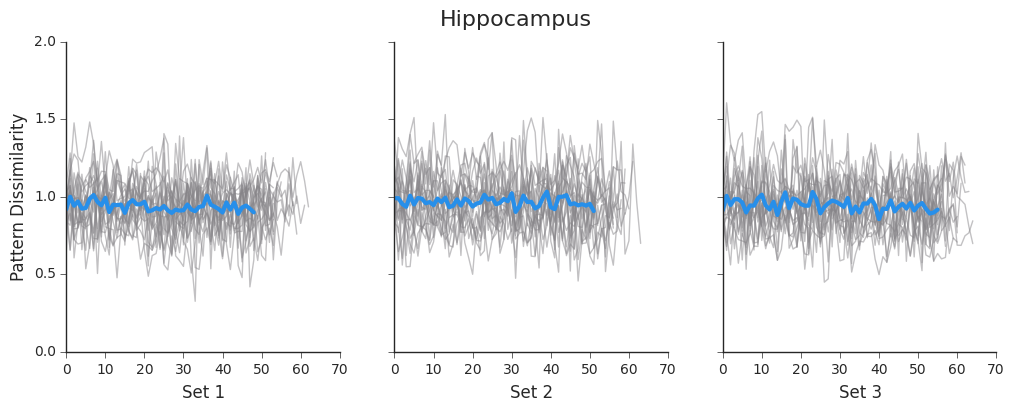

In [27]:
x_min = [] #max number of trials for each set
for i in range(3):
    temp = [len(hp_corrs['set{0}'.format(i+1)][sub]) for sub in hp_corrs['set{0}'.format(i+1)]] #lens of sub correlations
    x_min.append(np.min(temp)) #return largest value for the current set       
shaved_dict = {'set1':[], 'set2':[], 'set3':[]}
for i, key in enumerate(shaved_dict.keys()):
    for j, sub_line in enumerate(hp_corrs[key]):
        shaved_dict[key].append(sub_line[:x_min[i]])

fig, (ax0, ax1, ax2) = plt.subplots(ncols = 3, figsize = (12, 4), sharex = True, sharey = True)
sns.despine(top=True)
plt.suptitle('Hippocampus', size = 16)
axes = [ax0, ax1, ax2]
for i in range(3):
    for j, sub_line in enumerate(hp_corrs['set{0}'.format(i+1)]):
        x = range(len(hp_corrs['set{0}'.format(i+1)][j]))
        axes[i].plot(x, hp_corrs['set{0}'.format(i+1)][j], color = '#878589', linewidth = 1, alpha = 0.5)
        axes[i].yaxis.set_ticks_position('left')
        axes[i].xaxis.set_ticks_position('bottom')
        if i == 0:
            axes[i].set_ylabel('Pattern Dissimilarity', size = 12)
        axes[i].set_xlabel('Set {0}'.format(i+1), size = 12)
        axes[i].set_ylim(0,2)
    x2 = range(len(np.mean(shaved_dict['set{0}'.format(i+1)], axis = 0)))
    axes[i].plot(x2, np.mean(shaved_dict['set{0}'.format(i+1)], axis = 0), '#278fea', linewidth = 3)

## Medial PFC

In [28]:
mpfc_concat = {'set1':[], 'set2':[], 'set3':[]}

for x, SID in enumerate(sids):
    for sets in range(3):
        mpfc_concat['set{0}'.format(sets+1)].append(np.concatenate((all_corrs_df['mpfc']['run{0}'.format(sets*2+1)][x],
                                                                    all_corrs_df['mpfc']['run{0}'.format(sets*2+2)][x])))
mpfc_corrs = pd.DataFrame(mpfc_concat)

In [29]:
mpfc_counts = {'set1_>1':[], 'set1_<1':[], 'set2_>1':[], 'set2_<1':[], 'set3_>1':[], 'set3_<1':[]}

for x, SID in enumerate(sids):
    for key in mpfc_corrs.keys():   
        greater1 = []
        less1 = []
        for corr in mpfc_corrs[key][x]:
            if corr >= 1:
                greater1.append(corr)
            else:
                less1.append(corr)
        mpfc_counts['{0}_>1'.format(key)].append(len(greater1))
        mpfc_counts['{0}_<1'.format(key)].append(len(less1))
        
mpfc_counts_df = pd.DataFrame(mpfc_counts)

In [31]:
mpfc_counts_df

,set1_<1,set1_>1,set2_<1,set2_>1,set3_<1,set3_>1
0,43,11,35,17,53,8
1,43,16,35,22,35,26
2,35,18,50,7,37,23
3,20,43,28,33,52,6
4,46,10,35,22,57,5
5,37,15,35,25,37,19
6,24,31,48,11,23,34
7,27,27,24,30,11,52
8,25,26,22,31,31,28
9,29,23,26,32,34,22


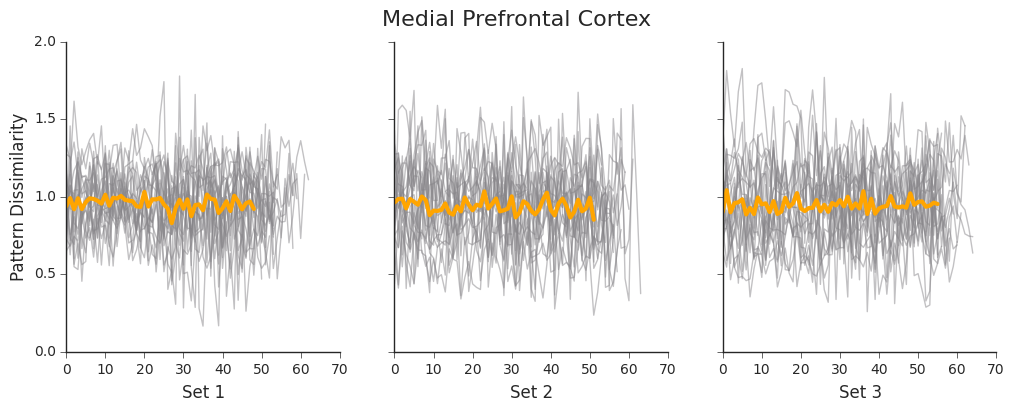

In [30]:
x_min = [] #max number of trials for each set
for i in range(3):
    temp = [len(mpfc_corrs['set{0}'.format(i+1)][sub]) for sub in mpfc_corrs['set{0}'.format(i+1)]] 
    x_min.append(np.min(temp))      
shaved_dict = {'set1':[], 'set2':[], 'set3':[]}
for i, key in enumerate(shaved_dict.keys()):
    for j, sub_line in enumerate(mpfc_corrs[key]):
        shaved_dict[key].append(sub_line[:x_min[i]])

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12,4), sharex=True, sharey=True)
sns.despine(top=True)
plt.suptitle('Medial Prefrontal Cortex', size=16)
axes = [ax0, ax1, ax2]
for i in range(3):
    for j, sub_line in enumerate(mpfc_corrs['set{0}'.format(i+1)]):
        x = range(len(mpfc_corrs['set{0}'.format(i+1)][j]))
        axes[i].plot(x, mpfc_corrs['set{0}'.format(i+1)][j], color='#878589', linewidth=1, alpha=0.5)
        axes[i].yaxis.set_ticks_position('left')
        axes[i].xaxis.set_ticks_position('bottom')
        if i == 0:
            axes[i].set_ylabel('Pattern Dissimilarity', size=12)
        axes[i].set_xlabel('Set {0}'.format(i+1), size=12)
        axes[i].set_ylim(0,2)
    x2 = range(len(np.mean(shaved_dict['set{0}'.format(i+1)], axis=0)))
    axes[i].plot(x2, np.mean(shaved_dict['set{0}'.format(i+1)], axis=0), color='orange', linewidth=3)

## Caudate

In [33]:
caud_concat = {'set1':[], 'set2':[], 'set3':[]}

for x, SID in enumerate(sids):
    for sets in range(3):
        caud_concat['set{0}'.format(sets+1)].append(np.concatenate((all_corrs_df['caud']['run{0}'.format(sets*2+1)][x],
                                                                    all_corrs_df['caud']['run{0}'.format(sets*2+2)][x])))
caud_corrs = pd.DataFrame(caud_concat)

In [34]:
caud_counts = {'set1_>1':[], 'set1_<1':[], 'set2_>1':[], 'set2_<1':[], 'set3_>1':[], 'set3_<1':[]}

for x, SID in enumerate(sids):
    for key in caud_corrs.keys():   
        greater1 = []
        less1 = []
        for corr in caud_corrs[key][x]:
            if corr >= 1:
                greater1.append(corr)
            else:
                less1.append(corr)
        caud_counts['{0}_>1'.format(key)].append(len(greater1))
        caud_counts['{0}_<1'.format(key)].append(len(less1))
        
caud_counts_df = pd.DataFrame(caud_counts)

In [35]:
caud_counts_df

,set1_<1,set1_>1,set2_<1,set2_>1,set3_<1,set3_>1
0,24,30,48,4,53,8
1,57,2,31,26,38,23
2,39,14,49,8,49,11
3,36,27,37,24,53,5
4,42,14,30,27,44,18
5,25,27,32,28,43,13
6,39,16,52,7,38,19
7,43,11,35,19,40,23
8,29,22,29,24,56,3
9,25,27,25,33,43,13


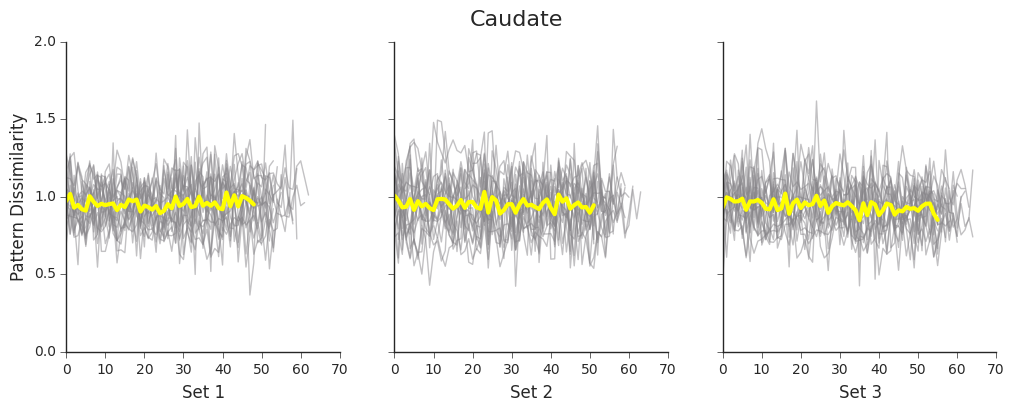

In [36]:
x_min = [] #max number of trials for each set
for i in range(3):
    temp = [len(caud_corrs['set{0}'.format(i+1)][sub]) for sub in caud_corrs['set{0}'.format(i+1)]] 
    x_min.append(np.min(temp))      
shaved_dict = {'set1':[], 'set2':[], 'set3':[]}
for i, key in enumerate(shaved_dict.keys()):
    for j, sub_line in enumerate(caud_corrs[key]):
        shaved_dict[key].append(sub_line[:x_min[i]])

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12,4), sharex=True, sharey=True)
sns.despine(top=True)
plt.suptitle('Caudate', size=16)
axes = [ax0, ax1, ax2]
for i in range(3):
    for j, sub_line in enumerate(caud_corrs['set{0}'.format(i+1)]):
        x = range(len(caud_corrs['set{0}'.format(i+1)][j]))
        axes[i].plot(x, caud_corrs['set{0}'.format(i+1)][j], color='#878589', linewidth=1, alpha=0.5)
        axes[i].yaxis.set_ticks_position('left')
        axes[i].xaxis.set_ticks_position('bottom')
        if i == 0:
            axes[i].set_ylabel('Pattern Dissimilarity', size=12)
        axes[i].set_xlabel('Set {0}'.format(i+1), size=12)
        axes[i].set_ylim(0,2)
    x2 = range(len(np.mean(shaved_dict['set{0}'.format(i+1)], axis=0)))
    axes[i].plot(x2, np.mean(shaved_dict['set{0}'.format(i+1)], axis=0), color='yellow', linewidth=3)

## Putamen

In [37]:
put_concat = {'set1':[], 'set2':[], 'set3':[]}

for x, SID in enumerate(sids):
    for sets in range(3):
        put_concat['set{0}'.format(sets+1)].append(np.concatenate((all_corrs_df['put']['run{0}'.format(sets*2+1)][x],
                                                                   all_corrs_df['put']['run{0}'.format(sets*2+2)][x])))
put_corrs = pd.DataFrame(put_concat)

In [38]:
put_counts = {'set1_>1':[], 'set1_<1':[], 'set2_>1':[], 'set2_<1':[], 'set3_>1':[], 'set3_<1':[]}

for x, SID in enumerate(sids):
    for key in put_corrs.keys():   
        greater1 = []
        less1 = []
        for corr in put_corrs[key][x]:
            if corr >= 1:
                greater1.append(corr)
            else:
                less1.append(corr)
        put_counts['{0}_>1'.format(key)].append(len(greater1))
        put_counts['{0}_<1'.format(key)].append(len(less1))
        
put_counts_df = pd.DataFrame(put_counts)

In [39]:
put_counts_df

,set1_<1,set1_>1,set2_<1,set2_>1,set3_<1,set3_>1
0,31,23,40,12,57,4
1,49,10,53,4,35,26
2,32,21,52,5,38,22
3,33,30,32,29,49,9
4,49,7,41,16,51,11
5,24,28,46,14,44,12
6,41,14,49,10,34,23
7,37,17,32,22,31,32
8,27,24,39,14,51,8
9,36,16,26,32,41,15


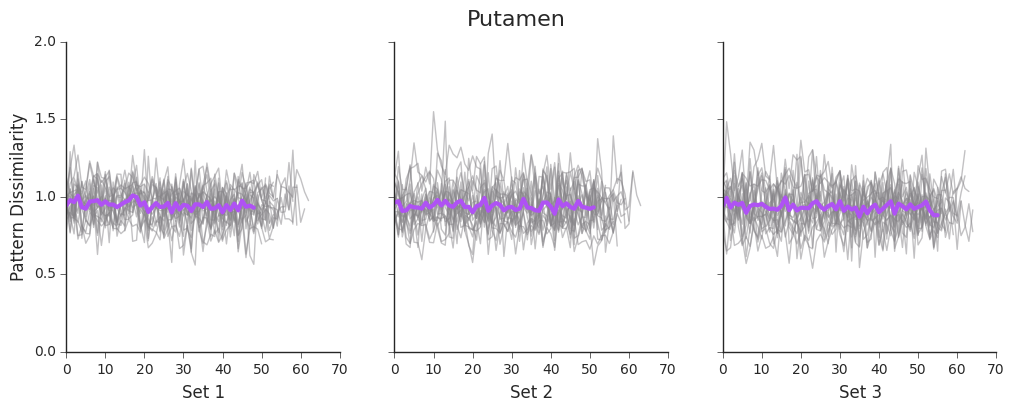

In [40]:
x_min = [] #max number of trials for each set
for i in range(3):
    temp = [len(put_corrs['set{0}'.format(i+1)][sub]) for sub in put_corrs['set{0}'.format(i+1)]] 
    x_min.append(np.min(temp))      
shaved_dict = {'set1':[], 'set2':[], 'set3':[]}
for i, key in enumerate(shaved_dict.keys()):
    for j, sub_line in enumerate(put_corrs[key]):
        shaved_dict[key].append(sub_line[:x_min[i]])

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12,4), sharex=True, sharey=True)
sns.despine(top=True)
plt.suptitle('Putamen', size=16)
axes = [ax0, ax1, ax2]
for i in range(3):
    for j, sub_line in enumerate(put_corrs['set{0}'.format(i+1)]):
        x = range(len(put_corrs['set{0}'.format(i+1)][j]))
        axes[i].plot(x, put_corrs['set{0}'.format(i+1)][j], color='#878589', linewidth=1, alpha=0.5)
        axes[i].yaxis.set_ticks_position('left')
        axes[i].xaxis.set_ticks_position('bottom')
        if i == 0:
            axes[i].set_ylabel('Pattern Dissimilarity', size=12)
        axes[i].set_xlabel('Set {0}'.format(i+1), size=12)
        axes[i].set_ylim(0,2)
    x2 = range(len(np.mean(shaved_dict['set{0}'.format(i+1)], axis=0)))
    axes[i].plot(x2, np.mean(shaved_dict['set{0}'.format(i+1)], axis=0), color='#af52f4', linewidth=3)

## Ventral Occipital

In [41]:
vocc_concat = {'set1':[], 'set2':[], 'set3':[]}

for x, SID in enumerate(sids):
    for sets in range(3):
        vocc_concat['set{0}'.format(sets+1)].append(np.concatenate((all_corrs_df['vocc']['run{0}'.format(sets*2+1)][x],
                                                                    all_corrs_df['vocc']['run{0}'.format(sets*2+2)][x])))
vocc_corrs = pd.DataFrame(vocc_concat)

In [42]:
vocc_counts = {'set1_>1':[], 'set1_<1':[], 'set2_>1':[], 'set2_<1':[], 'set3_>1':[], 'set3_<1':[]}

for x, SID in enumerate(sids):
    for key in vocc_corrs.keys():   
        greater1 = []
        less1 = []
        for corr in vocc_corrs[key][x]:
            if corr >= 1:
                greater1.append(corr)
            else:
                less1.append(corr)
        vocc_counts['{0}_>1'.format(key)].append(len(greater1))
        vocc_counts['{0}_<1'.format(key)].append(len(less1))
        
vocc_counts_df = pd.DataFrame(vocc_counts)

In [43]:
vocc_counts_df

,set1_<1,set1_>1,set2_<1,set2_>1,set3_<1,set3_>1
0,35,19,39,13,61,0
1,31,28,28,29,23,38
2,18,35,26,31,1,59
3,20,43,11,50,29,29
4,29,27,23,34,15,47
5,27,25,39,21,32,24
6,19,36,35,24,17,40
7,38,16,28,26,25,38
8,11,40,6,47,27,32
9,17,35,15,43,3,53


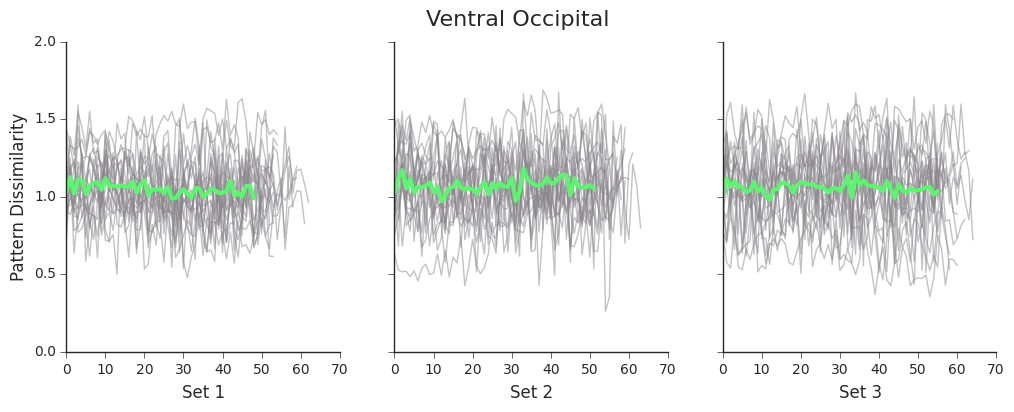

In [44]:
x_min = [] #max number of trials for each set
for i in range(3):
    temp = [len(vocc_corrs['set{0}'.format(i+1)][sub]) for sub in vocc_corrs['set{0}'.format(i+1)]] 
    x_min.append(np.min(temp))      
shaved_dict = {'set1':[], 'set2':[], 'set3':[]}
for i, key in enumerate(shaved_dict.keys()):
    for j, sub_line in enumerate(vocc_corrs[key]):
        shaved_dict[key].append(sub_line[:x_min[i]])

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12,4), sharex=True, sharey=True)
sns.despine(top=True)
plt.suptitle('Ventral Occipital', size=16)
axes = [ax0, ax1, ax2]
for i in range(3):
    for j, sub_line in enumerate(vocc_corrs['set{0}'.format(i+1)]):
        x = range(len(vocc_corrs['set{0}'.format(i+1)][j]))
        axes[i].plot(x, vocc_corrs['set{0}'.format(i+1)][j], color='#878589', linewidth=1, alpha=0.5)
        axes[i].yaxis.set_ticks_position('left')
        axes[i].xaxis.set_ticks_position('bottom')
        if i == 0:
            axes[i].set_ylabel('Pattern Dissimilarity', size=12)
        axes[i].set_xlabel('Set {0}'.format(i+1), size=12)
        axes[i].set_ylim(0,2)
    x2 = range(len(np.mean(shaved_dict['set{0}'.format(i+1)], axis=0)))
    axes[i].plot(x2, np.mean(shaved_dict['set{0}'.format(i+1)], axis=0), color='#5bf56f', linewidth=3)